# First Part is from "How To Deal With Imbalanced Classification, Without Re-balancing the Data"  by David Rosen 

https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3
## Second Part is down below

In [1]:
import datetime
print(datetime.datetime.now())
import numpy as np
import pandas as pd
import re
from sklearn import metrics, model_selection
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
df=pd.read_csv('creditcard.csv')
df.info()

2021-09-08 12:27:26.016225
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-nu

In [2]:
df.Class.sum(),df.Class.mean()

(492, 0.001727485630620034)

## split into train and test and train the model

In [3]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(
        df.loc[:,'V1':'Amount'], df.Class,  stratify=df.Class, 
        test_size=0.3, random_state=42)
gbc=HistGradientBoostingClassifier(learning_rate=0.01, 
        max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
        n_iter_no_change=15, random_state=42).fit(Xtrain,ytrain)

In [4]:
[type(x) for x in (Xtrain, Xtest, ytrain, ytest)]

[pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series]

In [5]:
ytrain,ytest

(249927    0
 214082    0
 106005    0
 58619     0
 191638    0
          ..
 3441      0
 233802    0
 85418     0
 29062     0
 17677     0
 Name: Class, Length: 199364, dtype: int64,
 186882    0
 165754    0
 235285    0
 101271    0
 5832      0
          ..
 64725     0
 16688     0
 183868    0
 45011     0
 150527    0
 Name: Class, Length: 85443, dtype: int64)

## apply the full model to the test data as a hard classifier with (implicit) decision threshold 0.5

In other words, this classifier tells us which class is more probable than the other according to the model

In [6]:
hardpredtst=gbc.predict(Xtest)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
display(conf_matrix(ytest,hardpredtst))

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 85285 (TNR = 99.99%),FP = 10 (FPR = 0.01%)
True 1(Fraud),FN = 42 (FNR = 28.38%),TP = 106 (TPR = 71.62%)


The true pos rate (Recall of class 1 (frauds)) is too low -- we want to identify more than 72% of frauds as such

Ultimately it is a business decision what threshold to apply when deciding whether to approve a transaction, as it is a trade-off between false approvals and false rejections.

## plot the true positive rate and false positive rate as a function of threshold to manage the trade-off

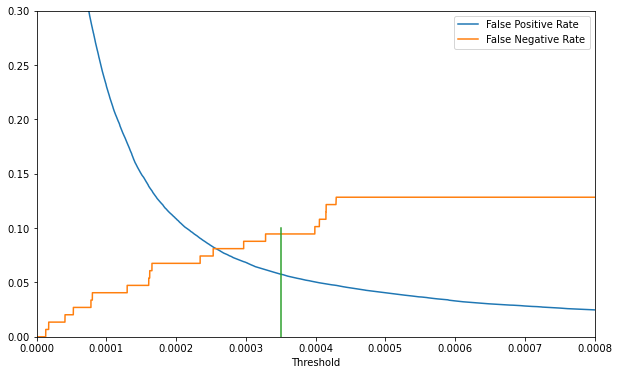

In [7]:
predtst=gbc.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(ytest, predtst)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.00035,0.00035],[0,0.1]) #mark example thresh.
ax.set_xbound(0,0.0008); ax.set_ybound(0,0.3) #zoom in

## choose a threshold of 0.00035 (0.035%) (vertical green line shown) which will give us a false negative (approved fraud) rate of about 9% and a false positive (rejected legitimate) rate of about 6%

In [8]:
hardpredtst_tuned_thresh = np.where(predtst >= 0.00035, 1, 0)
conf_matrix(ytest, hardpredtst_tuned_thresh)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 80388 (TNR = 94.25%),FP = 4907 (FPR = 5.75%)
True 1(Fraud),FN = 14 (FNR = 9.46%),TP = 134 (TPR = 90.54%)


Sure enough, False neg rate of 9.46% (i.e. identified/denied 90.54% of our frauds) and false pos rt of 5.75% (i.e. still approved 94.25% of our legitimate transactions).

# This second part is for "How to determine confidence intervals for your model performance, like "92.4% [89.6% to 94.7%]", for any metric such as Accuracy, Recall, Precision, Specificity, F1 and others" by David Rosen 

(you can find it via http://dabruro.medium.com/) 

## Original test set and two generated bootstrap sample datasets

In [9]:
import numpy as np
import pandas as pd
import re
def make_boot_df(dforig):
    """Returns one boot sample dataframe, same shape as dforig
    """
    return dforig.sample(frac=1,replace=True).reset_index(drop=True)

In [10]:
# reset random row nums from #train_test_split() #before #concat!
ytest=ytest.reset_index(drop=True) #else #concat #ignore_index=True
hardpredtst_tuned_thresh = pd.Series\
  (hardpredtst_tuned_thresh, name='PredClass') #was #Numpy #array
dforig = pd.concat([ytest, hardpredtst_tuned_thresh], axis=1)

np.random.seed(13)  # to get same #sample #datasets #every #time
df0, df1 = make_boot_df(dforig), make_boot_df(dforig)
pd.concat([dforig,df0,df1], axis=1, keys=['Orig','Boot0','Boot1'])

Orig           Boot0           Boot1          
      Class PredClass Class PredClass Class PredClass
0         0         0     0         0     0         0
1         0         0     0         0     0         0
2         0         0     0         1     0         0
3         0         0     0         0     0         0
4         0         0     0         0     0         0
...     ...       ...   ...       ...   ...       ...
85438     0         0     0         0     0         0
85439     0         1     0         0     0         0
85440     0         0     0         0     0         0
85441     0         0     0         0     0         0
85442     0         0     0         0     0         0

[85443 rows x 6 columns]

## Making each boot sample dataset and calculating metrics for it

In [11]:
from tqdm import trange
DFLT_NBOOTS=500
def raw_metric_samples(metrics, *data_args, nboots=DFLT_NBOOTS, sort=False,
       **metric_kwargs):
    """Return dataframe containing metric(s) for nboots boot sample datasets.
    metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    if callable(metrics): metrics=[metrics] # single metric func to list
    metrics=list(metrics) # in case it is a generator
    dforig=pd.DataFrame\
    ( { arg.name if hasattr(arg,'name') else str(i) : np.array(arg)
          for i,arg in enumerate(data_args) 
      }# end of dict comprehen.; np.array() removes index
    ) # I like ( ) to be above one another
    res=pd.DataFrame\
    ( # dictionary comprehension:
      { b:[ m( *[col_as_arg for (colname,col_as_arg) in dfboot.items()],
               **_kws_this_metric(m,**metric_kwargs)
             ) for m in metrics # list comprehension ends w/following "]":
          ] for b,dfboot in # generator expr. avoids huge mem. of *list* of df's:
            ((b,make_boot_df(dforig)) for b in trange(nboots))
            if dfboot.iloc[:,0].nunique()>1 # >1 for log loss (no labels), roc
      }, index=[_metric_name(m) for m in metrics]
    ) # sorry but I like ( ) to be above #one #another:-)
    res.index.name="Metric (class 1 +ve)"
    return res.apply(lambda row: np.sort(row), axis=1) if sort else res
from sklearn import metrics
def specificity_score(true,pred, **kwargs):
    return metrics.recall_score(1-pd.Series(true), 1-pd.Series(pred), **kwargs)
specificity_score.__name__ = "Specificity (Recall of −ve)"
def _kws_this_metric(m,**metric_kwargs):
    # dict of just those metric_kwargs that this metric accepts
    return \
    { k: metric_kwargs[k] for k in metric_kwargs.keys()
           & m.__wrapped__.__kwdefaults__.keys() # intersect
    } if ( hasattr(m,"__wrapped__") and
               hasattr(m.__wrapped__,"__kwdefaults__") and
               isinstance(m.__wrapped__.__kwdefaults__, dict) 
         ) else dict() # no keywords if attribs aren't there
def _metric_name(m):
    name=re.sub(' score$','',m.__name__.replace('_',' '))
    return name.title() if name.lower()==name else name

In [12]:
met=[ metrics.recall_score, specificity_score, 
      metrics.balanced_accuracy_score
    ]
np.random.seed(13)
raw_metric_samples(met, ytest, hardpredtst_tuned_thresh, 
         nboots=10).style.format('{:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.67it/s]


,0,1,2,3,4,5,6,7,8,9
Metric (class 1 +ve),,,,,,,,,,
Recall,93.46%,89.81%,96.62%,89.38%,89.57%,89.68%,82.82%,89.74%,88.07%,85.71%
Specificity (Recall of −ve),94.29%,94.14%,94.29%,94.35%,94.27%,94.09%,94.28%,94.21%,94.14%,94.22%
Balanced Accuracy,93.88%,91.98%,95.45%,91.86%,91.92%,91.88%,88.55%,91.98%,91.11%,89.97%


## Histogram of bootstrap sample datasets showing confidence interval for Recall

In [13]:
metr = metrics.recall_score
point = metr(ytest, hardpredtst_tuned_thresh)
np.random.seed(13)
data = raw_metric_samples(metr, ytest, hardpredtst_tuned_thresh, 
               nboots=500).transpose()

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.69it/s]


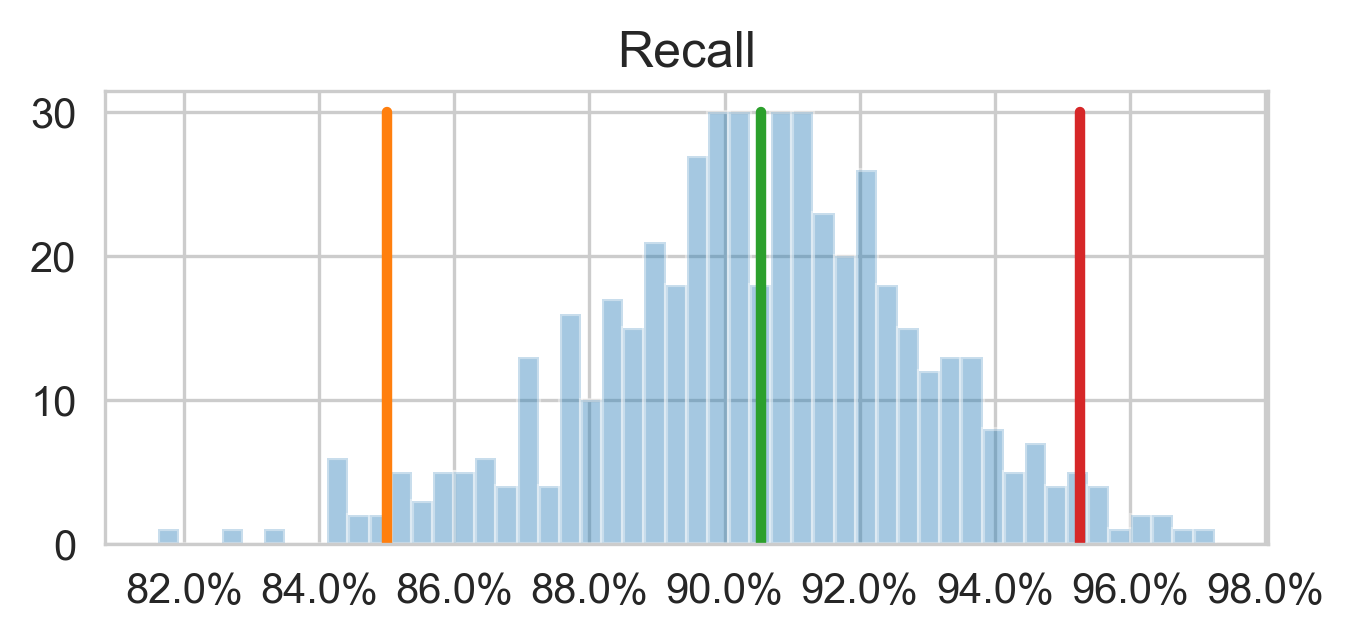

In [21]:
(lower, upper) = data.quantile([0.025, 0.975]).iloc[:,0]

import matplotlib, matplotlib.ticker as mtick
import seaborn as sns; sns.set_style('whitegrid')  #optional
matplotlib.rcParams["figure.dpi"] = 300
ax = data.hist(bins=50, figsize=(5, 2), alpha=0.4)[0][0]
ax.xaxis.set_major_formatter( mtick.PercentFormatter(1.0))
for x in lower, point, upper:
    ax.plot([x, x],[0, 30], lw=2.5)

## How to calculate all the confidence intervals

In [15]:
def ci(metrics, *data_args, quantiles=[0.025,0.975], 
           nboots=DFLT_NBOOTS, **metric_kwargs):
    """Return Pandas data frame of bootstrap confidence intervals. 
    PARAMETERS:
    metrics : a metric func or iterable of funcs e.g. [m1, m2, m3]
    data_args : 1+ (often 2, e.g. ytrue,ypred) iterables for metric 
    quantiles : [upper,lower] if for 1 CI (dflt is for 95% 2-tail)
    nboots : number of bootstrap samples drawn from data (dflt 500)
    metric_kwargs : each metric gets any KW's it accepts optionally
    """ # non-std expr fmt: ( ) above one another unless same line
    if callable(metrics): metrics=[metrics] # single metric func to list
    metrics=list(metrics) # in case it is a generator [expr]
    result=raw_metric_samples\
      (metrics, *data_args, nboots=nboots, sort=False, **metric_kwargs)
    resboots=result.shape[1]
    if resboots<nboots: print\
            ( f'Note: {nboots-resboots} bootstrap '
              f'samples dropped (out of {nboots}) because all '
              f'values were identical within first data arg'
            ) # results may be biased if too many were dropped
    result=result.apply(lambda row: row.quantile(quantiles),axis=1)
    result.columns=[f'{q*100}%ile' for q in quantiles]
    result.columns.name=f"{resboots} Boot Samples"
    result.insert\
    ( 0, "Point Estim", [ m( *[data_arg for data_arg in data_args], 
                             **_kws_this_metric(m,**metric_kwargs)
                           ) for m in metrics
                        ]# end of list compreh. of all metrics for col
    ) # inserted (in place) point estim col as first col (all metrics)
    return result

## Calculate the results!

In [16]:
np.random.seed(13)
ci(met,ytest, hardpredtst_tuned_thresh).style.format('{:.2%}')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


500 Boot Samples,Point Estim,2.5%ile,97.5%ile
Metric (class 1 +ve),,,
Recall,90.54%,85.00%,95.25%
Specificity (Recall of −ve),94.25%,94.11%,94.40%
Balanced Accuracy,92.39%,89.61%,94.73%


In [17]:
print(datetime.datetime.now())

2021-09-08 12:30:05.550411
